In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches, convert_to_one_hot
from functools import partial

%matplotlib inline

/home/dl/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def my_load_dataset():
    train_dataset = h5py.File('datasets/data_augmented_train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = my_load_dataset()

In [4]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 15120
number of test examples = 120
X_train shape: (12288, 15120)
Y_train shape: (6, 15120)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [5]:
# initialize parameters

def initialize_parameters(parameters, layer, dimension):
    
    parameters[layer] = {};
    parameters[layer]["W"] = tf.get_variable("W" + str(layer), dimension["W"], initializer = tf.contrib.layers.xavier_initializer());
    parameters[layer]["b"] = tf.get_variable("b" + str(layer), dimension["b"], initializer = tf.zeros_initializer())
    
    return parameters;

In [6]:
# forward propogation

def loss_with_droupout(A, keep_prob):
    if keep_prob != 1.0:
        return tf.nn.dropout(A, keep_prob);
    else:
        return A;

def without_dropout(A):
    return A;

def forward_propagation(X, parameters, hyperparameters, dropout = True):
    
    A = X
    
    layers = hyperparameters["layers"];
    
    false_dropout = 1 # tf.constant(1)
    
    for i in range(len(layers) - 1):
        A = tf.add(tf.matmul( parameters[i+1]["W"], A ), parameters[i+1]["b"])
        
        if(layers[i+1]["activation_function"] == "relu"):
            A = tf.nn.relu(A);
        if(layers[i+1]["activation_function"] == "relu6"):
            A = tf.nn.relu6(A);
        if(layers[i+1]["activation_function"] == "sigmoid"):
            A = tf.nn.sigmoid(A);
        if(layers[i+1]["activation_function"] == "leaky_relu"):
            A = tf.nn.leaky_relu(A);
        if(layers[i+1]["activation_function"] == "tanh"):
            A = tf.nn.tanh(A);
        if(layers[i+1]["activation_function"] == "tanh"):
            A = tf.nn.tanh(A);
        
        # dropout
        A = tf.cond(dropout, partial(loss_with_droupout, A, layers[i+1]["keep_prob"]), partial(without_dropout, A) );
        
    return A;

In [7]:
def compute_cost(logits, labels, parameters, hyperparameters, beta = 0):
    
    layers = hyperparameters["layers"];
    
    cost = tf.reduce_mean(
        # Maybe need transpose ?
        tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels)
        # Need regulurazation
    );
    
    # regularization
    for i in range(len(layers) - 1):
        if beta != 0:
            cost = tf.add(cost, tf.nn.l2_loss(parameters[i+1]["W"]) * beta);
    
    return cost;

In [8]:
# model

def model (X_train, Y_train, X_test, Y_test, hyperparameters, print_cost = True):
    
    layers = hyperparameters["layers"];
    epochs = hyperparameters["epochs"];
    minibatch_size = hyperparameters["minibatch_size"];
    
    learning_rate = hyperparameters["learning_rate"];
    beta = hyperparameters["beta"];
    
    # constant
#     learning_rate = tf.constant(hyperparameters["learning_rate"], name='learning_rate')
#     beta = tf.constant(hyperparameters["beta"], name='beta')
    
    
    ops.reset_default_graph()
    costs = []
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    # initialize weight and biases
    parameters = {}
    for i in range(len(layers)-1):
        parameters = initialize_parameters(parameters, i + 1, {"W": [layers[i+1]['neurons'], layers[i]['neurons']], "b": [layers[i+1]['neurons'], 1]});
    
    # Forward Propogation
    dropout = tf.placeholder(tf.bool, name = "dropout")
    logits = forward_propagation(X, parameters, hyperparameters, dropout);
    
    cost = compute_cost(tf.transpose(logits), tf.transpose(Y), parameters, hyperparameters, beta);
    
    # ...izer :-)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost);
    initializer = tf.global_variables_initializer();
    
    # Start session
    with tf.Session() as sess:
        # Run the initialization
        sess.run(initializer)
        
        # Do the training loop
        for epoch in range(epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, dropout: True})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(logits), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, dropout: False}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, dropout: False}))
        
        return parameters;

In [9]:
# hyperparameters searching

class tuning():
    
    def __init__(self):
        self.hyperparameters = {};
        self.hyperparameters['layers'] = [];
        
    def set_parameter(self, parameter_name, parameter_value):
        self.hyperparameters[parameter_name] = parameter_value;
        return self.hyperparameters;
    
    def set_layer(self, neurons, activation_function = "relu", keep_prob = 1):
        
        a = {};
        a['neurons'] = neurons;
        a['activation_function'] = activation_function;
        a['keep_prob'] = keep_prob;
        
        self.hyperparameters['layers'].append(a);
#         self.hyperparameters['layers'][layer_index] = {};
#         self.hyperparameters['layers'][layer_index]['neurons'] = neurons;
#         self.hyperparameters['layers'][layer_index]['keep_prob'] = keep_prob;
        return self.hyperparameters;


In [10]:
tune = tuning();

tune.set_parameter("learning_rate", 10e-5);
tune.set_parameter("epochs", 9000);
tune.set_parameter("minibatch_size", 256);
tune.set_parameter("beta", 10e-3);

tune.set_layer(12288, activation_function = "relu");
tune.set_layer(100, activation_function = "relu");
tune.set_layer(50, activation_function = "relu");
tune.set_layer(25, activation_function = "relu");
tune.set_layer(12, activation_function = "relu");
tune.set_layer(6, activation_function = "cost");


Instructions for updating:
Use the retry module or similar alternatives.
Cost after epoch 0: 3.307193
Cost after epoch 100: 1.261431
Cost after epoch 200: 1.001403
Cost after epoch 300: 0.866055
Cost after epoch 400: 0.781350
Cost after epoch 500: 0.723579
Cost after epoch 600: 0.695200
Cost after epoch 700: 0.662086
Cost after epoch 800: 0.647121
Cost after epoch 900: 0.752085
Cost after epoch 1000: 0.672540
Cost after epoch 1100: 0.647131
Cost after epoch 1200: 0.804999
Cost after epoch 1300: 0.626995
Cost after epoch 1400: 0.690261
Cost after epoch 1500: 0.607388
Cost after epoch 1600: 0.663853
Cost after epoch 1700: 0.605198
Cost after epoch 1800: 0.604564
Cost after epoch 1900: 0.648864
Cost after epoch 2000: 0.577285
Cost after epoch 2100: 0.632512
Cost after epoch 2200: 0.565552
Cost after epoch 2300: 0.634281
Cost after epoch 2400: 0.582021
Cost after epoch 2500: 0.621736
Cost after epoch 2600: 0.571860
Cost after epoch 2700: 0.574722
Cost after epoch 2800: 0.656302
Cost after 

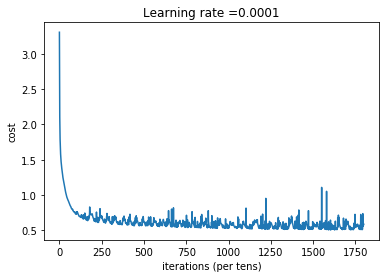

Parameters have been trained!
Train Accuracy: 0.8958995
Test Accuracy: 0.7583333


In [11]:
parameters = model (X_train, Y_train, X_test, Y_test, tune.hyperparameters)

In [12]:
def predict(X, parameters, hyperparameters):
    
    dropout = tf.placeholder(tf.bool, name = "dropout")
    x = tf.placeholder("float", [12288, 1])
    
    logits = forward_propagation(x, parameters, hyperparameters, dropout)
    p = tf.argmax(logits)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X, dropout: False})
        
    return prediction

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Sign 0 correct predicted :)
Sign 1 does NOT correct predicted :(
Sign 2 does NOT correct predicted :(
Sign 3 does NOT correct predicted :(
Sign 4 does NOT correct predicted :(
Sign 5 correct predicted :)


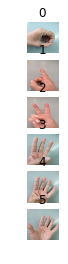

In [13]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_images   = ["my0.jpg", "my1.jpg", "my2.jpg", "my3.jpg", "my4.jpg", "my5.jpg"]
my_classess = [0,1,2,3,4,5]
## END CODE HERE ##

    

f, axarr = plt.subplots(len(my_images))
k = 0;
for i in range(0, len(my_images)):
    fname = "images/" + my_images[i]
    image = np.array(ndimage.imread(fname, flatten=False))
    my_image = scipy.misc.imresize(image, size=(64,64))
    
    # START PLOT
    k += 1;
    img = axarr[k - 1].imshow(my_image, interpolation='nearest')
    img.set_cmap('hot')
    axarr[k - 1].axis('off')
    axarr[k - 1].set_title(my_classess[i])
    # END PLOT
    
    my_image = my_image.reshape((1, 64*64*3)).T
    
    
    
    my_image_prediction = predict(my_image, parameters, tune.hyperparameters)
    
    if(my_image_prediction == my_classess[i]):
        print("Sign " + str(my_classess[i]) + " correct predicted :)")
    else:
        print("Sign " + str(my_classess[i]) + " does NOT correct predicted :(")


# print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))